## Install torch-geometric and other required packages

In [0]:
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

## Package Initialization

In [0]:
import numpy as np

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

## Upload training data to Google Colab VM

In [0]:
# upload training and testing data
from google.colab import files

uploaded = files.upload()

Saving 0.txt to 0.txt
Saving 0_score.txt to 0_score.txt
Saving 1.txt to 1.txt
Saving 1_score.txt to 1_score.txt


In [0]:
!ls

0_score.txt  0.txt  1_score.txt  1.txt	sample_data


## process training data and targets

In [0]:
# function to get torch_geometric.data.Data object from sythnetic graph
def get_synthetic_data(number = 0):

    # read network file
    edges = []
    with open(str(number) + ".txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            edge = line.split("\t")
            edge[0] = int(edge[0])
            edge[1] = int(edge[1])
            edges.append(edge)

        edges= torch.tensor(np.array(edges), dtype=torch.long)

    # read node score file
    node_scores = []
    with open("0_score.txt", "r") as file:
        lines = file.readlines();

        for line in lines:
            if len(line) == 0:
                continue
            sequences = line.split("\t")
            node_scores.append(float(sequences[1]))

        node_scores = torch.tensor(np.array(node_scores), dtype=torch.float)

    return (edges, node_scores)

In [0]:
edges, node_scores = get_synthetic_data(0)

In [0]:
print(edges)
print(node_scores)

In [0]:
node_number = node_scores.size()[0]

## Define DrBC Network

In [0]:
class DrBCNetwork(nn.Module):
    def __init__(self, input_dimension = 3, embedding_dimension = 128):
        super(DrBCNetwork, self).__init__()

        self.input_dimension = input_dimension
        self.embedding_dimension = embedding_dimension
        self.linear1 = nn.Linear(self.input_dimension, self.embedding_dimension, bias=False)
        self.gru_cell1 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.gru_cell2 = nn.GRUCell(self.embedding_dimension, self.embedding_dimension, bias=False)
        self.linear2 = nn.Linear(self.embedding_dimension, int(self.embedding_dimension / 2), bias=False)
        self.linear3 = nn.Linear(int(self.embedding_dimension / 2), 1, bias=False)

        # aggregation weights look-up table
        self.aggregation_weights = None
        
        # node neighborhood look-up table
        self.neighborhood = None

        # node degree list
        self.degrees = None


    # using another graph to train => recalculate self.aggregation and self.neighborhood
    def set_graph(self, graph):

        node_number = len(list(graph.nodes))

        # get degrees and neighborhood lookup
        self.neighborhood = torch.zeros([node_number, node_number], dtype=torch.bool)
        self.degrees = torch.zeros([node_number])

        for edge in graph.edges:
            source, target = edge
            self.neighborhood[source, target] = self.neighborhood[target, source] = 1
            self.degrees[source] += 1
            self.degrees[target] += 1

        # compute aggregation weights
        self.aggregation_weights = torch.zeros([node_number, node_number], dtype=torch.float32)

        sqrt_degrees = self.degrees.sqrt()
        for i in range(node_number):
            # if i % 100 == 0:
            #    print("calculating aggregation weights: {}/{}".format(i, node_number))
            for j in range(i):
                self.aggregation_weights[i, j] = 1 / (sqrt_degrees[i].item()*sqrt_degrees[j].item() + 1e-7)

        # make it diagonal symmetry matrix
        self.aggregation_weights = self.aggregation_weights.T + self.aggregation_weights
        sqrt_degrees = None
    
    def forward(self, x):

        # Encoding
        # ============================================================================================

        # x's shape: [node_number, 3] --> use all node without batching

        h0 = x
        h1 = F.normalize(F.relu(self.linear1(h0))) # h1: [node_number, embedding_dimension]

        # neighborhood aggregation: layer 2
        h2n =  torch.mm(self.neighborhood * self.aggregation_weights, h1) # h2n: [node_number, embedding_dimension]
        
        # combination: layer 2
        h2 = self.gru_cell1(h2n, h1) # h2: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h2 = F.normalize(h2)

        # neighborhood aggregation: layer 3
        h3n = torch.mm(self.neighborhood * self.aggregation_weights, h2) # h3n: [node_number, embedding_dimension]
        
        # combination: layer 3
        h3 = self.gru_cell2(h3n, h2) # h3: [node_number, embedding_dimenstion]

        # normalize the embedding vector
        h3 = F.normalize(h3)

        # layer aggregation: element-wise max pooling
        z = torch.max(torch.max(h1, h2), h3)

        # Decoding
        # ===========================================================================================

        # 1-st fully-connected
        z = self.linear2(z)
        z = F.relu(z)

        z = self.linear3(z)

        return z

    # return degree list of current used graph, size: [node_number]
    def get_graph_degrees(self):
        return self.degrees

## Define Loss Function

In [0]:
class PairwiseRankingLoss(nn.Module):
    def __init__(self, sample_number):
        super(PairwiseRankingLoss, self).__init__()
        self.sample_number = sample_number
        
    def forward(self, outputs, targets):

        errors = torch.zeros([self.sample_number])

        # draw samples from prediction outputs and targets
        for i in range(self.sample_number):
            perm = torch.randperm(outputs.size(0))
            index = perm[:2]
            y_diff = outputs[index][0].item() - outputs[index][1].item()
            b_diff = targets[index][0].item() - targets[index][1].item()

            errors[i] = (-1) * self.sigmoid(b_diff) * math.log( self.sigmoid(y_diff) ) - (1 - self.sigmoid(b_diff)) * math.log(1 - self.sigmoid(y_diff))

        return torch.sum(errors)

    def sigmoid(self, x):
        return (1 / (1 + math.exp( -1 * x )))

In [0]:
def SoftmaxLoss(outputs, targets):
    # softmax
    return torch.sum(torch.abs(F.softmax(outputs, dim=0) - F.softmax(targets, dim=0)))

## Build Training Procedure

Preparing validation graphs ...


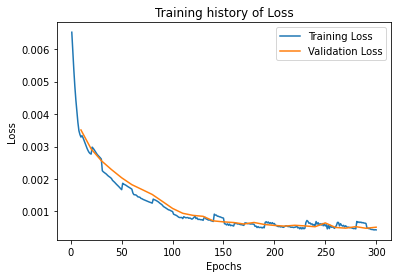

In [25]:
LOSS_VERBOSE = False
GRAPH_VERBOSE = False

TRAINING_GRAPHS = 30
GRAPH_NODES = 500
LEARNING_RATE = 0.0001
EPOCHS = 10
VALIDATION_GRAPHS = 1

INPUT_DIMENSION = 3
EMBEDDING_DIMENSION = 128

# create model entity
drbc = DrBCNetwork(input_dimension=INPUT_DIMENSION, embedding_dimension=EMBEDDING_DIMENSION)

# create optimizer (Adam used)
optimizer = optim.Adam(drbc.parameters(), lr=LEARNING_RATE)

# create set of graphs for validation
print("Preparing validation graphs ...")
validation_graphs = [nx.powerlaw_cluster_graph(n=GRAPH_NODES, m=4, p=0.05) for i in range(VALIDATION_GRAPHS)]
validation_scores = []
for g in validation_graphs:
    validation_scores.append(torch.Tensor(list(nx.betweenness_centrality(g).values())).unsqueeze(1))

# record the training loss
training_history = torch.zeros([TRAINING_GRAPHS * EPOCHS])
validation_history = torch.zeros([TRAINING_GRAPHS])

for i in range(TRAINING_GRAPHS):

    if (GRAPH_VERBOSE):
        print("=== Training on Graph {} ===".format(i))
    
    # generate graph G
    graph = nx.powerlaw_cluster_graph(n=GRAPH_NODES, m=4, p=0.05)
    
    # get betweeness centrality of graph's nodes, format it into scores
    node_scores = torch.Tensor(list(nx.betweenness_centrality(graph).values())).unsqueeze(1) # torch.Size([GRAPH_NODES, 1])

    # recalculate aggregation weights, neighborhood lookup and node degrees
    drbc.set_graph(graph)

    # prepare input data x
    degrees = drbc.get_graph_degrees()
    x = torch.ones([GRAPH_NODES, 3])
    for j in range(GRAPH_NODES):
        x[j][0] = degrees[j]

    # training
    for j in range(EPOCHS):
        optimizer.zero_grad()   # zero the gradient buffers
        z = drbc(x)
        loss = SoftmaxLoss(z, node_scores)

        if (j % 5 == 0 and LOSS_VERBOSE):
            print("Epoch {}'s loss: {}".format(j, loss))

        training_history[i*EPOCHS + j] = loss
        loss.backward()
        optimizer.step()

        # do validation at the last epochs
        if (j == (EPOCHS-1)):
            val_losses = torch.zeros([VALIDATION_GRAPHS])
            for k in range(VALIDATION_GRAPHS):
                drbc.set_graph(validation_graphs[k])

                # set model using validation graph
                deg = drbc.get_graph_degrees()

                # prepare input x for validation
                val_x = torch.ones([GRAPH_NODES, 3])
                for m in range(GRAPH_NODES):
                    val_x[m][0] = deg[m]

                val_z = drbc(val_x)
                val_losses[k] = SoftmaxLoss(val_z, validation_scores[k])
                validation_history[i] = torch.mean(val_losses)

# plot the loss
train_line, = plt.plot(np.arange(1, TRAINING_GRAPHS*EPOCHS+1, 1), training_history.detach().numpy(), label='Training Loss')
val_line, = plt.plot(np.arange(EPOCHS, TRAINING_GRAPHS*EPOCHS+1, EPOCHS), validation_history.detach().numpy(), label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training history of Loss")
plt.show()

## TODO
* [x] let model to fit on differet graph (re-calculate neighborhood lookup and aggregation lookup)
* [x] generate a synthetic graphic and use it in training
* [x] calculate validation error
* [ ] implement early stop
* [ ] calculate top-x% accuracy
* [ ] calculate error on test-synthetic and test-youtube dataset
* [ ] recording running time
* [ ] calculate Kendall tau distance
* [ ] compared to other methods

## Discussion
* How to handle if graph is highly dynamic (nodes' degrees change frequently)
* Epoch per graph and graph number for traing will lead to different ability of generalization
* Way to calculate validation
* How to implemenation early-stop?